In [789]:
from sklearn.datasets import make_circles

n_samples=1000

X , y=make_circles(n_samples,noise=0.03,random_state=42)

In [790]:
print(f'first 5 x features are : {X[:5]}')
print(f'first 5 y labels are : {y[:5]}')

first 5 x features are : [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 y labels are : [1 1 1 1 0]


In [791]:
import pandas as pd
circles=pd.DataFrame({'X1':X[:,0],
                      'X2':X[:,1],
                      'y':y[:]})
circles

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


In [792]:
circles.y.value_counts()


y
1    500
0    500
Name: count, dtype: int64

In [793]:
X.shape,y.shape

((1000, 2), (1000,))

In [794]:
X.ndim,y.ndim

(2, 1)

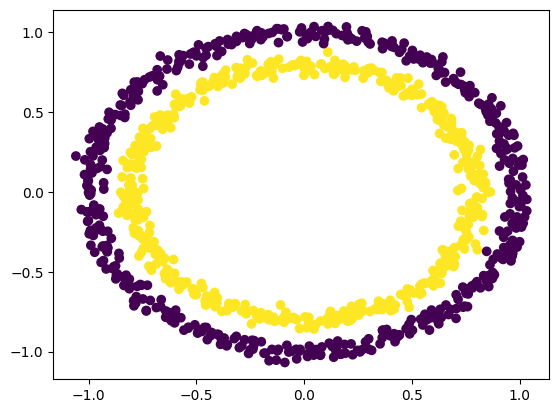

In [795]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y )

In [796]:
import torch
X=torch.from_numpy(X).type(torch.float)

y=torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [797]:
#splitting the data into train and test datasets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    X, y, test_size=0.2, random_state=42)

len(X_test),len(y_test),len(X_train),len(y_train)


(200, 200, 800, 800)

In [798]:
#building a model
import torch
from torch import nn
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [799]:
#constructing a model with nn.Module subclass
class circleModel0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=5)

    self.layer2=nn.Linear(in_features=5, out_features=1)

  def forward(self,x):
    return self.layer2(self.layer1(x))

model_0=circleModel0().to(device)
model_0

circleModel0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [800]:
#making predictions with untrained model
# untrained_pred=model_0(X_test.to(device))
untrained_pred = model_0(X_test.to(device))
print(f'length of predictions: {len(untrained_pred)}   shape: {untrained_pred.shape}')
print(f'length of test samples: {len(y_test)} shape{y_test.shape}')
print(f'first 10 predictions: {untrained_pred[:10]}')
print(f'first 10 test labels : {y_test[:10]}')

length of predictions: 200   shape: torch.Size([200, 1])
length of test samples: 200 shapetorch.Size([200])
first 10 predictions: tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)
first 10 test labels : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [801]:
#setting up loss fn and optimizer

loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [802]:
#creating evaluation matrix
#accuracy
def accuracy(y_true, y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [803]:
#training the model
#logits->prediction_prob->prediction_labels
y_logits=model_0(X_test.to(device))[:5]
y_logits


tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [804]:
y_pred_prob=torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [805]:
y_pred=torch.round(y_pred_prob)
# or u can do these step in a single line
y_pred_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))
y_pred.squeeze()


tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [806]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [807]:
#building a training and testing loop


#putting data into target device
X_train,y_train=X_train.to(device),y_train.to(device)

X_test,y_test=X_test.to(device),y_test.to(device)

In [808]:
torch.manual_seed(42)
epochs=100

#building a training and evaluation loop
for epoch in range(epochs):
  #training
  model_0.train()

  #forward pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #calculate loss
  loss=loss_fn(y_logits,y_train) # Using nn.BCEWithLogitsLoss works with raw logits so we used y_logits insted of y_pred
  acc=accuracy(y_true=y_train,y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testng loop
  model_0.eval()
  with torch.inference_mode():
    #forward pass
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #calculate loss
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_pred)

  if epoch%10==0:
    print(f'epoch: {epoch}    loss: {loss}   accuracy: {acc:.4f}        test loss: {test_loss:.4f}   test acc: {test_acc:.4f}')

epoch: 0    loss: 0.6956854462623596   accuracy: 50.0000        test loss: 0.6972   test acc: 50.0000
epoch: 10    loss: 0.6940255761146545   accuracy: 50.0000        test loss: 0.6962   test acc: 50.0000
epoch: 20    loss: 0.693427562713623   accuracy: 46.0000        test loss: 0.6959   test acc: 48.5000
epoch: 30    loss: 0.6932066082954407   accuracy: 49.0000        test loss: 0.6958   test acc: 47.5000
epoch: 40    loss: 0.6931198835372925   accuracy: 49.5000        test loss: 0.6957   test acc: 46.5000
epoch: 50    loss: 0.6930813789367676   accuracy: 50.3750        test loss: 0.6957   test acc: 46.5000
epoch: 60    loss: 0.6930606365203857   accuracy: 50.5000        test loss: 0.6956   test acc: 46.5000
epoch: 70    loss: 0.6930473446846008   accuracy: 50.5000        test loss: 0.6956   test acc: 46.5000
epoch: 80    loss: 0.6930372714996338   accuracy: 50.7500        test loss: 0.6955   test acc: 46.5000
epoch: 90    loss: 0.6930291652679443   accuracy: 50.3750        test loss:

In [809]:
#making predictions using the trained model
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
  print('already exists, skipping download')
else:
  print('downloading')
  request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

already exists, skipping download


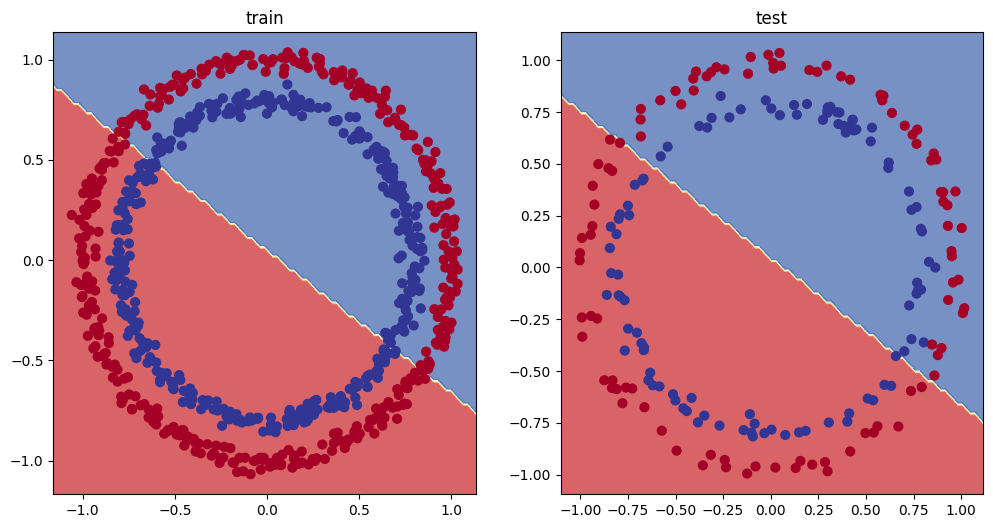

In [810]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_0,X_test,y_test)

# constructing model 2(with relu function used )

In [811]:
class circleModel1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2, out_features=10)
    self.layer2=nn.Linear(in_features=10, out_features=10)
    self.layer3=nn.Linear(in_features=10, out_features=1)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_1=circleModel1().to(device)
model_1

circleModel1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [812]:
X_train,y_train=X_train.to(device),y_train.to(device)

X_test,y_test=X_test.to(device),y_test.to(device)

In [813]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [814]:
torch.manual_seed(42)
epochs=5000

#building a training and evaluation loop
for epoch in range(epochs):
  #training
  model_1.train()

  #forward pass
  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #calculate loss
  loss=loss_fn(y_logits,y_train) # Using nn.BCEWithLogitsLoss works with raw logits so we used y_logits insted of y_pred
  acc=accuracy(y_true=y_train,y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #testng loop
  model_1.eval()
  with torch.inference_mode():
    #forward pass
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    #calculate loss
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy(y_true=y_test,y_pred=test_pred)

  if epoch%1000==0:
    print(f'epoch: {epoch}    loss: {loss}   accuracy: {acc:.4f}        test loss: {test_loss:.4f}   test acc: {test_acc:.4f}')

epoch: 0    loss: 0.6929463148117065   accuracy: 50.0000        test loss: 0.6932   test acc: 50.0000
epoch: 1000    loss: 0.5681842565536499   accuracy: 87.7500        test loss: 0.5738   test acc: 86.5000
epoch: 2000    loss: 0.04176006466150284   accuracy: 99.8750        test loss: 0.0658   test acc: 100.0000
epoch: 3000    loss: 0.016718436032533646   accuracy: 99.8750        test loss: 0.0336   test acc: 100.0000
epoch: 4000    loss: 0.010481315664947033   accuracy: 100.0000        test loss: 0.0245   test acc: 99.5000


In [815]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

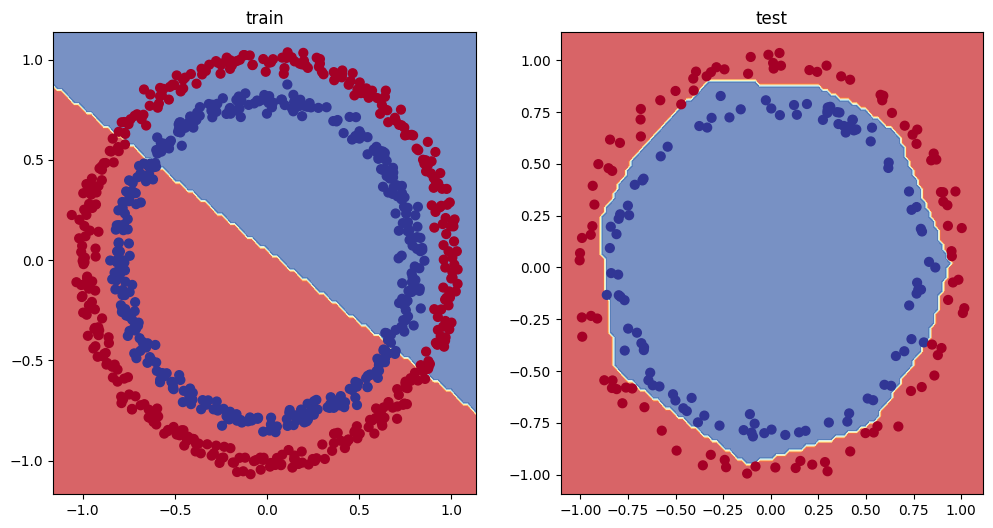

In [816]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('train')
plot_decision_boundary(model_0,X_train,y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_1,X_test,y_test)

# multi-class classification

In [817]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#setting up hyperparameters
num_classes=4
num_features=2
random_seed=42

#creating a multiclass data

X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=num_features,
                         centers=num_classes,
                         cluster_std=1.5,
                         random_state=random_seed)

In [818]:
#turn data into tensors
X_blob=torch.from_numpy(X_blob).type(torch.float)

y_blob=torch.from_numpy(y_blob).type(torch.float)

X_blob[:5],y_blob[:5]


(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3., 2., 2., 1., 1.]))

In [819]:
X_blob.dtype

torch.float32

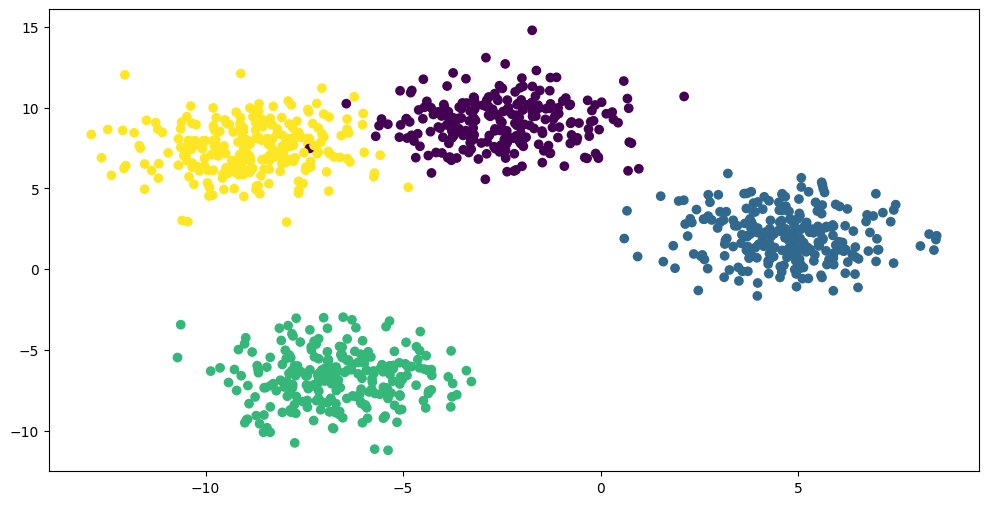

In [820]:
#splitting into train test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=42) #or random seed insted of 42

#plotting the data
plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0],X_blob[:,1], c=y_blob)

In [821]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [834]:
from torch import nn
class blobModel(nn.Module):
  def __init__(self,input_features,output_features, hidden_units=8):
    super().__init__()
    self.layer1=nn.Linear(in_features=input_features,out_features=hidden_units)
    self.layer2=nn.Linear(in_features=hidden_units,out_features=hidden_units)

    self.layer3=nn.Linear(in_features=hidden_units,out_features=output_features)
    self.relu=nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_new=blobModel(input_features=num_features,
                 output_features=num_classes,
                 hidden_units=8).to(device)
model_new

blobModel(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
)

In [835]:
#creating a loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_new.parameters(),lr=0.1)

In [824]:
#getting prediction prob for multiclass pytorch model
model_new(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [825]:
model_new(X_blob_train.to(device))[0].shape,num_classes

(torch.Size([4]), 4)

In [826]:
y_logits=model_new(X_blob_train.to(device))
#performing softmax calculation on logits
y_pred_prob=torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_prob[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)
tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], grad_fn=<SliceBackward0>)


In [827]:
torch.sum(y_pred_prob[0])

tensor(1., grad_fn=<SumBackward0>)

In [840]:
#creating a training and testing loop for multiclass model
torch.manual_seed(42)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_new.parameters(),lr=0.1)
epochs=1000
X_blob_train,y_blob_train=X_blob_train.to(device),y_blob_train.to(device).long()

X_blob_test,y_blob_test=X_blob_test.to(device),y_blob_test.to(device).long()

for epoch in range(epochs):
  model_new.train()

  #forward pass
  y_logits=model_new(X_blob_train)

  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  #calculate loss and accuracy
  loss=loss_fn(y_logits,y_blob_train)
  acc=accuracy(y_true=y_blob_train, y_pred=y_pred)

  #optimizer
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()


  #testing loop

  model_new.eval()
  with torch.inference_mode():

    #forward pass
    test_logits=model_new(X_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)

    #calculate loss and accuracy
    loss=loss_fn(test_logits,y_blob_test)
    acc=accuracy(y_true=y_blob_test, y_pred=test_pred)


  #tracking the progress
  if epoch%100==0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

# import torch
# import torch.nn as nn
# import torch.optim as optim

# torch.manual_seed(42)

# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(params=model_new.parameters(), lr=0.1)

# epochs = 1000
# X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device).long()
# X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device).long()



# for epoch in range(epochs):
#     model_new.train()

#     # Forward pass
#     y_logits = model_new(X_blob_train)
#     y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

#     # Calculate loss and accuracy
#     loss = loss_fn(y_logits, y_blob_train)
#     acc = accuracy(y_true=y_blob_train, y_pred=y_pred)

#     # Optimize
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Testing loop
#     model_new.eval()
#     with torch.no_grad():
#         # Forward pass
#         test_logits = model_new(X_blob_test)
#         test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

#         # Calculate loss and accuracy
#         test_loss = loss_fn(test_logits, y_blob_test)
#         test_acc = accuracy(y_true=y_blob_test, y_pred=test_pred)

#     # Tracking the progress
#     if epoch % 100 == 0:
#         print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.01095, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 100 | Loss: 0.01073, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 200 | Loss: 0.01052, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 300 | Loss: 0.01033, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 400 | Loss: 0.01015, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 500 | Loss: 0.00998, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 600 | Loss: 0.00981, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 700 | Loss: 0.00966, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 800 | Loss: 0.00950, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%
Epoch: 900 | Loss: 0.00935, Acc: 99.50% | Test Loss: 0.01095, Test Acc: 99.50%


In [841]:
 model_new.eval()
with torch.inference_mode():
    y_logits = model_new(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ -3.5152,  12.8726, -10.6701, -12.0424],
        [ -1.5874, -10.7021,  -7.4139,   5.5362],
        [ -4.9568,  -5.3038,   5.9000,  -4.7777],
        [ -4.1693,   9.9101,  -5.9159,  -7.2679],
        [  7.2882,  -3.9915, -13.0520,  -8.3689],
        [ -2.5079, -12.7236,  -8.5220,   7.2774],
        [ -4.2988,  -4.4822,   5.1063,  -3.9816],
        [  6.3063,  -7.6554, -10.6496,  -4.0647],
        [ -6.3999,  -6.8922,   7.3544,  -6.1132],
        [  7.0537,  -6.8103, -11.1074,  -5.3461]])

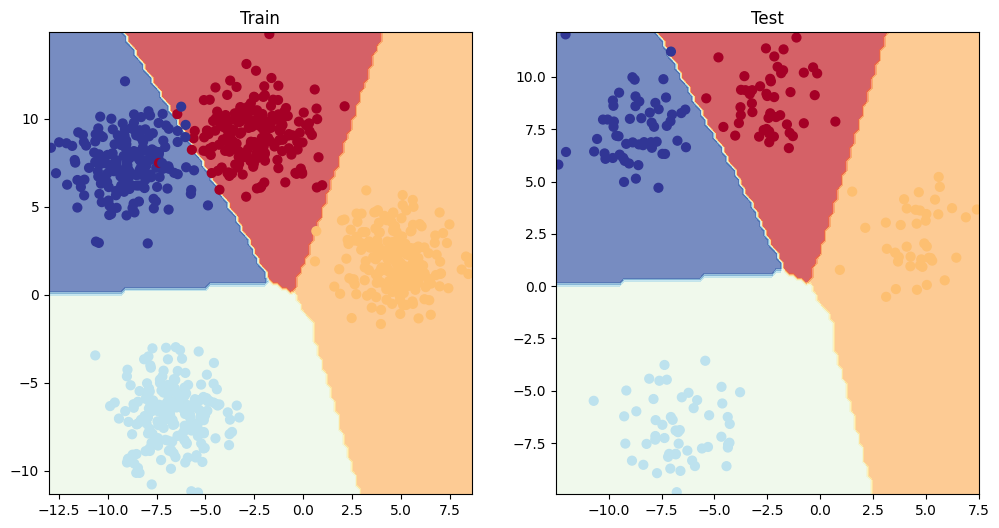

In [842]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_new, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_new, X_blob_test, y_blob_test)